In [57]:
import pandas as pd
import ast
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [58]:
def parse_json_column(column):
    return column.apply(ast.literal_eval)


def extract_keys_from_dict_list(dict_list):
    keys = set()
    for item in dict_list:
        keys.update(item.keys())
    return list(keys)


def flatten_json_data(df, column_name):
    data_list = []
    for item in df[column_name]:
        flattened_dict = {}
        for sub_dict in item["top"]:
            flattened_dict[sub_dict.get("key", "unknown_key")] = sub_dict.get(
                "value", None
            )
        data_list.append(flattened_dict)
    return pd.DataFrame(data_list)

def flatten_specs_data(df, column_name):
    data_list = []

    for item in df[column_name]:
        flattened_dict = {}

        for sub_dict in item.get("top", []):
            flattened_dict[sub_dict.get("key", "unknown_key")] = sub_dict.get(
                "value", None
            )

        for section in item.get("data", []):
            for sub_dict in section.get("list", []):
                column_key = (
                    f"{section['heading']}_{sub_dict.get('key', 'unknown_key')}"
                )
                flattened_dict[column_key] = sub_dict.get("value", None)

        data_list.append(flattened_dict)

    return pd.DataFrame(data_list)


def expand_data(df, location):

    df["new_car_detail"] = parse_json_column(df["new_car_detail"])
    df["new_car_overview"] = parse_json_column(df["new_car_overview"])
    df["new_car_feature"] = parse_json_column(df["new_car_feature"])
    df["new_car_specs"] = parse_json_column(df["new_car_specs"])

    df_detail = pd.json_normalize(df["new_car_detail"])
    df_overview = flatten_json_data(df, "new_car_overview")

    df_feature = df["new_car_feature"].apply(
        lambda x: {i: "Yes" for i in [item["value"] for item in x["top"]]}
    )
    df_feature = pd.json_normalize(df_feature)
    
    df_specs = flatten_specs_data(df, "new_car_specs")

    df_cleaned = pd.concat(
        [
            df.drop(
                [
                    "new_car_detail",
                    "new_car_overview",
                    "new_car_feature",
                    "new_car_specs",
                ],
                axis=1,
            ),
            df_detail,
            df_overview,
            df_feature,
            df_specs,
        ],
        axis=1,
    )

    df_cleaned["Location"] = location

    if df_cleaned.columns.duplicated().any():
        df_cleaned = df_cleaned.loc[:, ~df_cleaned.columns.duplicated()]

    return df_cleaned

In [59]:
bangalore_df = pd.read_excel(r"C:\Users\navee\OneDrive\Desktop\Car Dheko_Used Car Price Prediction\bangalore_cars.xlsx")
chennai_df = pd.read_excel(r"C:\Users\navee\OneDrive\Desktop\Car Dheko_Used Car Price Prediction\chennai_cars.xlsx")
delhi_df = pd.read_excel(r"C:\Users\navee\OneDrive\Desktop\Car Dheko_Used Car Price Prediction\delhi_cars.xlsx")
hyderabad_df = pd.read_excel(r"C:\Users\navee\OneDrive\Desktop\Car Dheko_Used Car Price Prediction\hyderabad_cars.xlsx")
jaipur_df = pd.read_excel(r"C:\Users\navee\OneDrive\Desktop\Car Dheko_Used Car Price Prediction\jaipur_cars.xlsx")
kolkata_df = pd.read_excel(r"C:\Users\navee\OneDrive\Desktop\Car Dheko_Used Car Price Prediction\kolkata_cars.xlsx")


In [60]:
bangalore_cleaned = expand_data(bangalore_df, "Bangalore")
chennai_cleaned = expand_data(chennai_df, "Chennai")
delhi_cleaned = expand_data(delhi_df, "Delhi")
hyderabad_cleaned = expand_data(hyderabad_df, "Hyderabad")
jaipur_cleaned = expand_data(jaipur_df, "Jaipur")
kolkata_cleaned = expand_data(kolkata_df, "Kolkata")

In [62]:
print(f"Number of columns in Bangalore: {bangalore_cleaned.shape[1]}")
print(f"Number of columns in Chennai: {chennai_cleaned.shape[1]}")
print(f"Number of columns in Delhi: {delhi_cleaned.shape[1]}")
print(f"Number of columns in Hyderabad: {hyderabad_cleaned.shape[1]}")
print(f"Number of columns in Jaipur: {jaipur_cleaned.shape[1]}")
print(f"Number of columns in Kolkata: {kolkata_cleaned.shape[1]}")

Number of columns in Bangalore: 123
Number of columns in Chennai: 121
Number of columns in Delhi: 131
Number of columns in Hyderabad: 126
Number of columns in Jaipur: 126
Number of columns in Kolkata: 122


In [63]:
combined_df = pd.concat(
    [
        bangalore_cleaned,
        chennai_cleaned,
        delhi_cleaned,
        hyderabad_cleaned,
        jaipur_cleaned,
        kolkata_cleaned,
    ],
    axis=0,
    ignore_index=True,
)

cols = combined_df.columns.tolist()
cols.remove("Location")
cols.append("Location")
combined_df = combined_df[cols]

In [65]:
combined_df

,car_links,it,ft,bt,km,transmission,ownerNo,owner,oem,model,...,Drive Modes,Digital Clock,Passenger Air Bag,Rear Folding Table,Driving Experience Control Eco,Engine Immobilizer,Rear Spoiler,Alloy Wheels,LEDDRLs,Location
0,https://www.cardekho.com/used-car-details/used...,0,Petrol,Hatchback,"1,20,000",Manual,3,3rd Owner,Maruti,Maruti Celerio,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bangalore
1,https://www.cardekho.com/buy-used-car-details/...,0,Petrol,SUV,"32,706",Manual,2,2nd Owner,Ford,Ford Ecosport,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bangalore
2,https://www.cardekho.com/used-car-details/used...,0,Petrol,Hatchback,"11,949",Manual,1,1st Owner,Tata,Tata Tiago,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bangalore
3,https://www.cardekho.com/buy-used-car-details/...,0,Petrol,Sedan,"17,794",Manual,1,1st Owner,Hyundai,Hyundai Xcent,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bangalore
4,https://www.cardekho.com/used-car-details/used...,0,Diesel,SUV,"60,000",Manual,1,1st Owner,Maruti,Maruti SX4 S Cross,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bangalore
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8364,https://www.cardekho.com/used-car-details/used...,0,Petrol,Hatchback,"10,000",Manual,1,1st Owner,Maruti,Maruti Celerio,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Kolkata
8365,https://www.cardekho.com/used-car-details/used...,0,Petrol,Hatchback,"1,20,000",Manual,1,1st Owner,Maruti,Maruti Alto 800,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Kolkata
8366,https://www.cardekho.com/used-car-details/used...,0,Petrol,Sedan,"50,000",Automatic,3,3rd Owner,Mercedes-Benz,Mercedes-Benz C-Class,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Kolkata
8367,https://www.cardekho.com/used-car-details/used...,0,Petrol,Hatchback,"40,000",Manual,1,1st Owner,Maruti,Maruti Ritz,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Kolkata


In [66]:
columns_to_check = [
    'Power Steering', 'Power Windows Front', 'Air Conditioner', 'Heater',
    'Adjustable Head Lights', 'Manually Adjustable Exterior Rear View Mirror',
    'Centeral Locking', 'Child Safety Locks', 'Fog Lights Front',
    'Anti Lock Braking System', 'Cd Player', 'Radio',
    'Power Adjustable Exterior Rear View Mirror', 'Brake Assist',
    'Electric Folding Rear View Mirror', 'Power Door Locks',
    'Cd Changer', 'Fog Lights Rear', 'Remote Trunk Opener', 'Tinted Glass',
    'Halogen Headlamps', 'Usb Auxiliary Input', 'Passenger Side Rear View Mirror',
    'Cassette Player', 'Day Night Rear View Mirror', 'Power Windows Rear',
    'Leather Seats', 'Leather Steering Wheel', 'Rear Seat Belts',
    'Remote Fuel Lid Opener', 'Bluetooth', 'Speakers Front', 'Power Antenna',
    'Dvd Player', 'Audio System Remote Control', 'Wheel Covers',
    'Rear Window Wiper', 'Driver Air Bag', 'Low Fuel Warning Light',
    'Cup Holders Front', 'Navigation System', 'Tachometer', 'Glove Compartment',
    'Integrated2Din Audio', 'Digital Odometer', 'Fabric Upholstery',
    'Accessory Power Outlet', 'Rear Seat Headrest', 'Speakers Rear',
    'Adjustable Steering', 'Anti Theft Alarm', 'Number Of Speaker'
]

features_series = combined_df[columns_to_check].notnull().sum(axis=1)

combined_df = pd.concat([combined_df.drop(columns=columns_to_check), features_series.rename('features')], axis=1)

In [67]:
interior_columns = [
    'Miscellaneous_Seating Capacity', 'Miscellaneous_Steering Type', 'Miscellaneous_Turning Radius',
    'Air Quality Control', 'Electronic Multi Tripmeter', 'Trunk Light', 'Vanity Mirror',
    'Rear Window Defogger', 'Adjustable Seats', 'Tyre Pressure Monitor', 'Touch Screen',
    'Integrated Antenna', 'Multifunction Steering Wheel', 'Sun Roof', 'Moon Roof',
    'Side Air Bag Front', 'Cruise Control', 'Drive Modes', 'Digital Clock',
    'Passenger Air Bag', 'Rear Folding Table', 'Driving Experience Control Eco'
]
interior_series = combined_df[interior_columns].notnull().sum(axis=1)

combined_df = pd.concat([combined_df.drop(columns=interior_columns), interior_series.rename('interior')], axis=1)

In [68]:
exterior_columns = [
    'Engine and Transmission_Engine Type', 'Engine and Transmission_Displacement',
    'Engine and Transmission_Max Power', 'Engine and Transmission_Max Torque',
    'Engine and Transmission_No of Cylinder', 'Engine and Transmission_Values per Cylinder',
    'Engine and Transmission_Value Configuration', 'Engine and Transmission_Fuel Suppy System',
    'Engine and Transmission_BoreX Stroke', 'Engine and Transmission_Compression Ratio',
    'Engine and Transmission_Turbo Charger', 'Engine and Transmission_Super Charger',
    'Dimensions & Capacity_Length', 'Dimensions & Capacity_Width',
    'Dimensions & Capacity_Height', 'Dimensions & Capacity_Wheel Base',
    'Dimensions & Capacity_Front Tread', 'Dimensions & Capacity_Rear Tread',
    'Dimensions & Capacity_Kerb Weight', 'Dimensions & Capacity_Gross Weight',
    'Miscellaneous_Gear Box', 'Miscellaneous_Drive Type', 'Miscellaneous_Front Brake Type',
    'Miscellaneous_Rear Brake Type', 'Miscellaneous_Top Speed', 'Miscellaneous_Acceleration',
    'Miscellaneous_Tyre Type', 'Miscellaneous_No Door Numbers', 'Miscellaneous_Cargo Volumn',
    'Wheel Size', 'Miscellaneous_Alloy Wheel Size', 'Dimensions & Capacity_Ground Clearance Unladen',
    'Rear Spoiler', 'Alloy Wheels', 'LEDDRLs'
]

exterior_series = combined_df[exterior_columns].notnull().sum(axis=1)

combined_df = pd.concat([combined_df.drop(columns=exterior_columns), exterior_series.rename('exterior')], axis=1)

In [69]:
len(combined_df.columns)

40

In [70]:
combined_df = combined_df.drop(columns=['car_links', 'it', 'ft','owner','centralVariantId','priceActual','priceSaving','priceFixedText','trendingText.imgUrl','trendingText.heading','trendingText.desc','Registration Year','Kms Driven','RTO','Ownership','Transmission','Engine','Engine Immobilizer'])
combined_df

,bt,km,transmission,ownerNo,oem,model,modelYear,variantName,price,Insurance Validity,...,Engine Displacement,Year of Manufacture,Mileage,Max Power,Torque,Engine and Transmission_Color,Location,features,interior,exterior
0,Hatchback,"1,20,000",Manual,3,Maruti,Maruti Celerio,2015,VXI,₹ 4 Lakh,Third Party insurance,...,998 cc,2015.0,23.1 kmpl,67.04bhp,90Nm,White,Bangalore,8,3,29
1,SUV,"32,706",Manual,2,Ford,Ford Ecosport,2018,1.5 Petrol Titanium BSIV,₹ 8.11 Lakh,Comprehensive,...,1497 cc,2018.0,17 kmpl,121.31bhp,150Nm,White,Bangalore,9,3,27
2,Hatchback,"11,949",Manual,1,Tata,Tata Tiago,2018,1.2 Revotron XZ,₹ 5.85 Lakh,Comprehensive,...,1199 cc,2018.0,23.84 kmpl,84bhp,114Nm,Red,Bangalore,9,3,30
3,Sedan,"17,794",Manual,1,Hyundai,Hyundai Xcent,2014,1.2 Kappa S Option,₹ 4.62 Lakh,Comprehensive,...,1197 cc,2014.0,19.1 kmpl,81.86bhp,113.75Nm,Others,Bangalore,9,3,28
4,SUV,"60,000",Manual,1,Maruti,Maruti SX4 S Cross,2015,DDiS 200 Zeta,₹ 7.90 Lakh,Third Party insurance,...,1248 cc,2015.0,23.65 kmpl,88.5bhp,200Nm,Gray,Bangalore,9,3,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8364,Hatchback,"10,000",Manual,1,Maruti,Maruti Celerio,2022,ZXI BSVI,₹ 5.10 Lakh,Third Party insurance,...,998 cc,2022.0,25.24 kmpl,65.71bhp,89Nm,Others,Kolkata,9,2,20
8365,Hatchback,"1,20,000",Manual,1,Maruti,Maruti Alto 800,2014,LXI,₹ 1.80 Lakh,Third Party insurance,...,796 cc,2014.0,22.74 kmpl,47.3bhp,69Nm,Others,Kolkata,8,3,27
8366,Sedan,"50,000",Automatic,3,Mercedes-Benz,Mercedes-Benz C-Class,2011,C 200 CGI Elegance,₹ 5.50 Lakh,Third Party insurance,...,1796 cc,2011.0,11.74 kmpl,186bhp,285Nm,Others,Kolkata,9,3,29
8367,Hatchback,"40,000",Manual,1,Maruti,Maruti Ritz,2012,ZXi,₹ 1.40 Lakh,Third Party insurance,...,1197 cc,2012.0,18.5 kmpl,85.80bhp,114Nm,Others,Kolkata,9,3,29


In [71]:
def clean_and_convert_column(df, column, dtype, remove_chars=None, unit=None, multiply_factor=1):
    if column in df.columns:
        df[column] = df[column].astype(str)
        if remove_chars:
            for char in remove_chars:
                df[column] = df[column].replace(char, '', regex=True)
        if unit:
            df[column] = df[column].str.replace(unit, '', regex=True)
        df[column] = pd.to_numeric(df[column], errors='coerce') * multiply_factor
        df[column] = df[column].fillna(0)
        if dtype == 'float':
            df[column] = df[column].astype(float)
        else:
            df[column] = df[column].astype(int)

In [72]:
clean_and_convert_column(combined_df, 'price', 'int', remove_chars=['₹', ','], unit='Lakh', multiply_factor=100000)
clean_and_convert_column(combined_df, 'Seats', 'int', remove_chars=[' Seats'])
clean_and_convert_column(combined_df, 'Engine Displacement', 'int', remove_chars=[' cc'])
clean_and_convert_column(combined_df, 'Mileage', 'float', remove_chars=[' kmpl'])
clean_and_convert_column(combined_df, 'Max Power', 'float', remove_chars=['bhp'])
clean_and_convert_column(combined_df, 'Torque', 'int', remove_chars=['Nm'])

In [73]:
if 'km' in combined_df.columns:
    combined_df['km'] = combined_df['km'].replace(',', '', regex=True).astype(int)

In [74]:
if 'Year of Manufacture' in combined_df.columns:
    combined_df['Year of Manufacture'] = combined_df['Year of Manufacture'].fillna(0).astype(int)

In [76]:
combined_df

,bt,km,transmission,ownerNo,oem,model,modelYear,variantName,price,Insurance Validity,...,Engine Displacement,Year of Manufacture,Mileage,Max Power,Torque,Engine and Transmission_Color,Location,features,interior,exterior
0,Hatchback,120000,Manual,3,Maruti,Maruti Celerio,2015,VXI,400000,Third Party insurance,...,998,2015,23.10,67.04,90,White,Bangalore,8,3,29
1,SUV,32706,Manual,2,Ford,Ford Ecosport,2018,1.5 Petrol Titanium BSIV,811000,Comprehensive,...,1497,2018,17.00,121.31,150,White,Bangalore,9,3,27
2,Hatchback,11949,Manual,1,Tata,Tata Tiago,2018,1.2 Revotron XZ,585000,Comprehensive,...,1199,2018,23.84,84.00,114,Red,Bangalore,9,3,30
3,Sedan,17794,Manual,1,Hyundai,Hyundai Xcent,2014,1.2 Kappa S Option,462000,Comprehensive,...,1197,2014,19.10,81.86,113,Others,Bangalore,9,3,28
4,SUV,60000,Manual,1,Maruti,Maruti SX4 S Cross,2015,DDiS 200 Zeta,790000,Third Party insurance,...,1248,2015,23.65,88.50,200,Gray,Bangalore,9,3,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8364,Hatchback,10000,Manual,1,Maruti,Maruti Celerio,2022,ZXI BSVI,509999,Third Party insurance,...,998,2022,25.24,65.71,89,Others,Kolkata,9,2,20
8365,Hatchback,120000,Manual,1,Maruti,Maruti Alto 800,2014,LXI,180000,Third Party insurance,...,796,2014,22.74,47.30,69,Others,Kolkata,8,3,27
8366,Sedan,50000,Automatic,3,Mercedes-Benz,Mercedes-Benz C-Class,2011,C 200 CGI Elegance,550000,Third Party insurance,...,1796,2011,11.74,186.00,285,Others,Kolkata,9,3,29
8367,Hatchback,40000,Manual,1,Maruti,Maruti Ritz,2012,ZXi,140000,Third Party insurance,...,1197,2012,18.50,85.80,114,Others,Kolkata,9,3,29


In [77]:
print(combined_df.dtypes)

bt                                object
km                                 int64
transmission                      object
ownerNo                            int64
oem                               object
model                             object
modelYear                          int64
variantName                       object
price                              int64
Insurance Validity                object
Fuel Type                         object
Seats                              int64
Engine Displacement                int64
Year of Manufacture                int64
Mileage                          float64
Max Power                        float64
Torque                             int64
Engine and Transmission_Color     object
Location                          object
features                           int64
interior                           int64
exterior                           int64
dtype: object


In [78]:
new_column_names = {
    'bt': 'Body_type',
    'km': 'Kilometer_Driven',
    'transmission': 'Transmission',
    'ownerNo': 'Owner_No.',
    'oem': 'Original_equipment_manufacturer',
    'model': 'Model',
    'modelYear': 'Model_year',
    'variantName': 'Variant_name',
    'price': 'Price',
    'Insurance Validity': 'Insurance_validity',
    'Fuel Type': 'Fuel_type',
    'Engine Displacement': 'Engine_displacement',
    'Year of Manufacture': 'Year_of_manufacture',
    'Mileage': 'Mileage',
    'Max Power': 'Max_power',
    'Torque': 'Torque',
    'Engine and Transmission_Color': 'Colour',
    'features': 'Features',
    'interior': 'Interior',
    'exterior': 'Exterior'
}
combined_df.rename(columns=new_column_names, inplace=True)

combined_df

,Body_type,Kilometer_Driven,Transmission,Owner_No.,Original_equipment_manufacturer,Model,Model_year,Variant_name,Price,Insurance_validity,...,Engine_displacement,Year_of_manufacture,Mileage,Max_power,Torque,Colour,Location,Features,Interior,Exterior
0,Hatchback,120000,Manual,3,Maruti,Maruti Celerio,2015,VXI,400000,Third Party insurance,...,998,2015,23.10,67.04,90,White,Bangalore,8,3,29
1,SUV,32706,Manual,2,Ford,Ford Ecosport,2018,1.5 Petrol Titanium BSIV,811000,Comprehensive,...,1497,2018,17.00,121.31,150,White,Bangalore,9,3,27
2,Hatchback,11949,Manual,1,Tata,Tata Tiago,2018,1.2 Revotron XZ,585000,Comprehensive,...,1199,2018,23.84,84.00,114,Red,Bangalore,9,3,30
3,Sedan,17794,Manual,1,Hyundai,Hyundai Xcent,2014,1.2 Kappa S Option,462000,Comprehensive,...,1197,2014,19.10,81.86,113,Others,Bangalore,9,3,28
4,SUV,60000,Manual,1,Maruti,Maruti SX4 S Cross,2015,DDiS 200 Zeta,790000,Third Party insurance,...,1248,2015,23.65,88.50,200,Gray,Bangalore,9,3,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8364,Hatchback,10000,Manual,1,Maruti,Maruti Celerio,2022,ZXI BSVI,509999,Third Party insurance,...,998,2022,25.24,65.71,89,Others,Kolkata,9,2,20
8365,Hatchback,120000,Manual,1,Maruti,Maruti Alto 800,2014,LXI,180000,Third Party insurance,...,796,2014,22.74,47.30,69,Others,Kolkata,8,3,27
8366,Sedan,50000,Automatic,3,Mercedes-Benz,Mercedes-Benz C-Class,2011,C 200 CGI Elegance,550000,Third Party insurance,...,1796,2011,11.74,186.00,285,Others,Kolkata,9,3,29
8367,Hatchback,40000,Manual,1,Maruti,Maruti Ritz,2012,ZXi,140000,Third Party insurance,...,1197,2012,18.50,85.80,114,Others,Kolkata,9,3,29


In [79]:
combined_df.head()

,Body_type,Kilometer_Driven,Transmission,Owner_No.,Original_equipment_manufacturer,Model,Model_year,Variant_name,Price,Insurance_validity,...,Engine_displacement,Year_of_manufacture,Mileage,Max_power,Torque,Colour,Location,Features,Interior,Exterior
0,Hatchback,120000,Manual,3,Maruti,Maruti Celerio,2015,VXI,400000,Third Party insurance,...,998,2015,23.10,67.04,90,White,Bangalore,8,3,29
1,SUV,32706,Manual,2,Ford,Ford Ecosport,2018,1.5 Petrol Titanium BSIV,811000,Comprehensive,...,1497,2018,17.00,121.31,150,White,Bangalore,9,3,27
2,Hatchback,11949,Manual,1,Tata,Tata Tiago,2018,1.2 Revotron XZ,585000,Comprehensive,...,1199,2018,23.84,84.00,114,Red,Bangalore,9,3,30
3,Sedan,17794,Manual,1,Hyundai,Hyundai Xcent,2014,1.2 Kappa S Option,462000,Comprehensive,...,1197,2014,19.10,81.86,113,Others,Bangalore,9,3,28
4,SUV,60000,Manual,1,Maruti,Maruti SX4 S Cross,2015,DDiS 200 Zeta,790000,Third Party insurance,...,1248,2015,23.65,88.50,200,Gray,Bangalore,9,3,27


In [80]:
from sklearn.preprocessing import MinMaxScaler

In [81]:
numerical_columns = ['Price']
scaler_2 = MinMaxScaler()

scaler_2.fit(combined_df[numerical_columns])

combined_df[numerical_columns] = scaler_2.transform(combined_df[numerical_columns])
combined_df

,Body_type,Kilometer_Driven,Transmission,Owner_No.,Original_equipment_manufacturer,Model,Model_year,Variant_name,Price,Insurance_validity,...,Engine_displacement,Year_of_manufacture,Mileage,Max_power,Torque,Colour,Location,Features,Interior,Exterior
0,Hatchback,120000,Manual,3,Maruti,Maruti Celerio,2015,VXI,0.000040,Third Party insurance,...,998,2015,23.10,67.04,90,White,Bangalore,8,3,29
1,SUV,32706,Manual,2,Ford,Ford Ecosport,2018,1.5 Petrol Titanium BSIV,0.000081,Comprehensive,...,1497,2018,17.00,121.31,150,White,Bangalore,9,3,27
2,Hatchback,11949,Manual,1,Tata,Tata Tiago,2018,1.2 Revotron XZ,0.000059,Comprehensive,...,1199,2018,23.84,84.00,114,Red,Bangalore,9,3,30
3,Sedan,17794,Manual,1,Hyundai,Hyundai Xcent,2014,1.2 Kappa S Option,0.000046,Comprehensive,...,1197,2014,19.10,81.86,113,Others,Bangalore,9,3,28
4,SUV,60000,Manual,1,Maruti,Maruti SX4 S Cross,2015,DDiS 200 Zeta,0.000079,Third Party insurance,...,1248,2015,23.65,88.50,200,Gray,Bangalore,9,3,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8364,Hatchback,10000,Manual,1,Maruti,Maruti Celerio,2022,ZXI BSVI,0.000051,Third Party insurance,...,998,2022,25.24,65.71,89,Others,Kolkata,9,2,20
8365,Hatchback,120000,Manual,1,Maruti,Maruti Alto 800,2014,LXI,0.000018,Third Party insurance,...,796,2014,22.74,47.30,69,Others,Kolkata,8,3,27
8366,Sedan,50000,Automatic,3,Mercedes-Benz,Mercedes-Benz C-Class,2011,C 200 CGI Elegance,0.000055,Third Party insurance,...,1796,2011,11.74,186.00,285,Others,Kolkata,9,3,29
8367,Hatchback,40000,Manual,1,Maruti,Maruti Ritz,2012,ZXi,0.000014,Third Party insurance,...,1197,2012,18.50,85.80,114,Others,Kolkata,9,3,29


In [82]:
min_price = combined_df['Price'].min()
max_price = combined_df['Price'].max()
print("Min:", min_price, "Max:", max_price)

Min: 0.0 Max: 1.0


In [83]:
combined_df

,Body_type,Kilometer_Driven,Transmission,Owner_No.,Original_equipment_manufacturer,Model,Model_year,Variant_name,Price,Insurance_validity,...,Engine_displacement,Year_of_manufacture,Mileage,Max_power,Torque,Colour,Location,Features,Interior,Exterior
0,Hatchback,120000,Manual,3,Maruti,Maruti Celerio,2015,VXI,0.000040,Third Party insurance,...,998,2015,23.10,67.04,90,White,Bangalore,8,3,29
1,SUV,32706,Manual,2,Ford,Ford Ecosport,2018,1.5 Petrol Titanium BSIV,0.000081,Comprehensive,...,1497,2018,17.00,121.31,150,White,Bangalore,9,3,27
2,Hatchback,11949,Manual,1,Tata,Tata Tiago,2018,1.2 Revotron XZ,0.000059,Comprehensive,...,1199,2018,23.84,84.00,114,Red,Bangalore,9,3,30
3,Sedan,17794,Manual,1,Hyundai,Hyundai Xcent,2014,1.2 Kappa S Option,0.000046,Comprehensive,...,1197,2014,19.10,81.86,113,Others,Bangalore,9,3,28
4,SUV,60000,Manual,1,Maruti,Maruti SX4 S Cross,2015,DDiS 200 Zeta,0.000079,Third Party insurance,...,1248,2015,23.65,88.50,200,Gray,Bangalore,9,3,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8364,Hatchback,10000,Manual,1,Maruti,Maruti Celerio,2022,ZXI BSVI,0.000051,Third Party insurance,...,998,2022,25.24,65.71,89,Others,Kolkata,9,2,20
8365,Hatchback,120000,Manual,1,Maruti,Maruti Alto 800,2014,LXI,0.000018,Third Party insurance,...,796,2014,22.74,47.30,69,Others,Kolkata,8,3,27
8366,Sedan,50000,Automatic,3,Mercedes-Benz,Mercedes-Benz C-Class,2011,C 200 CGI Elegance,0.000055,Third Party insurance,...,1796,2011,11.74,186.00,285,Others,Kolkata,9,3,29
8367,Hatchback,40000,Manual,1,Maruti,Maruti Ritz,2012,ZXi,0.000014,Third Party insurance,...,1197,2012,18.50,85.80,114,Others,Kolkata,9,3,29


In [84]:
combined_df.to_csv(r"C:\Users\navee\OneDrive\Desktop\Car Dheko_Used Car Price Prediction\finalcombined_cars.csv", index=False)

In [85]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

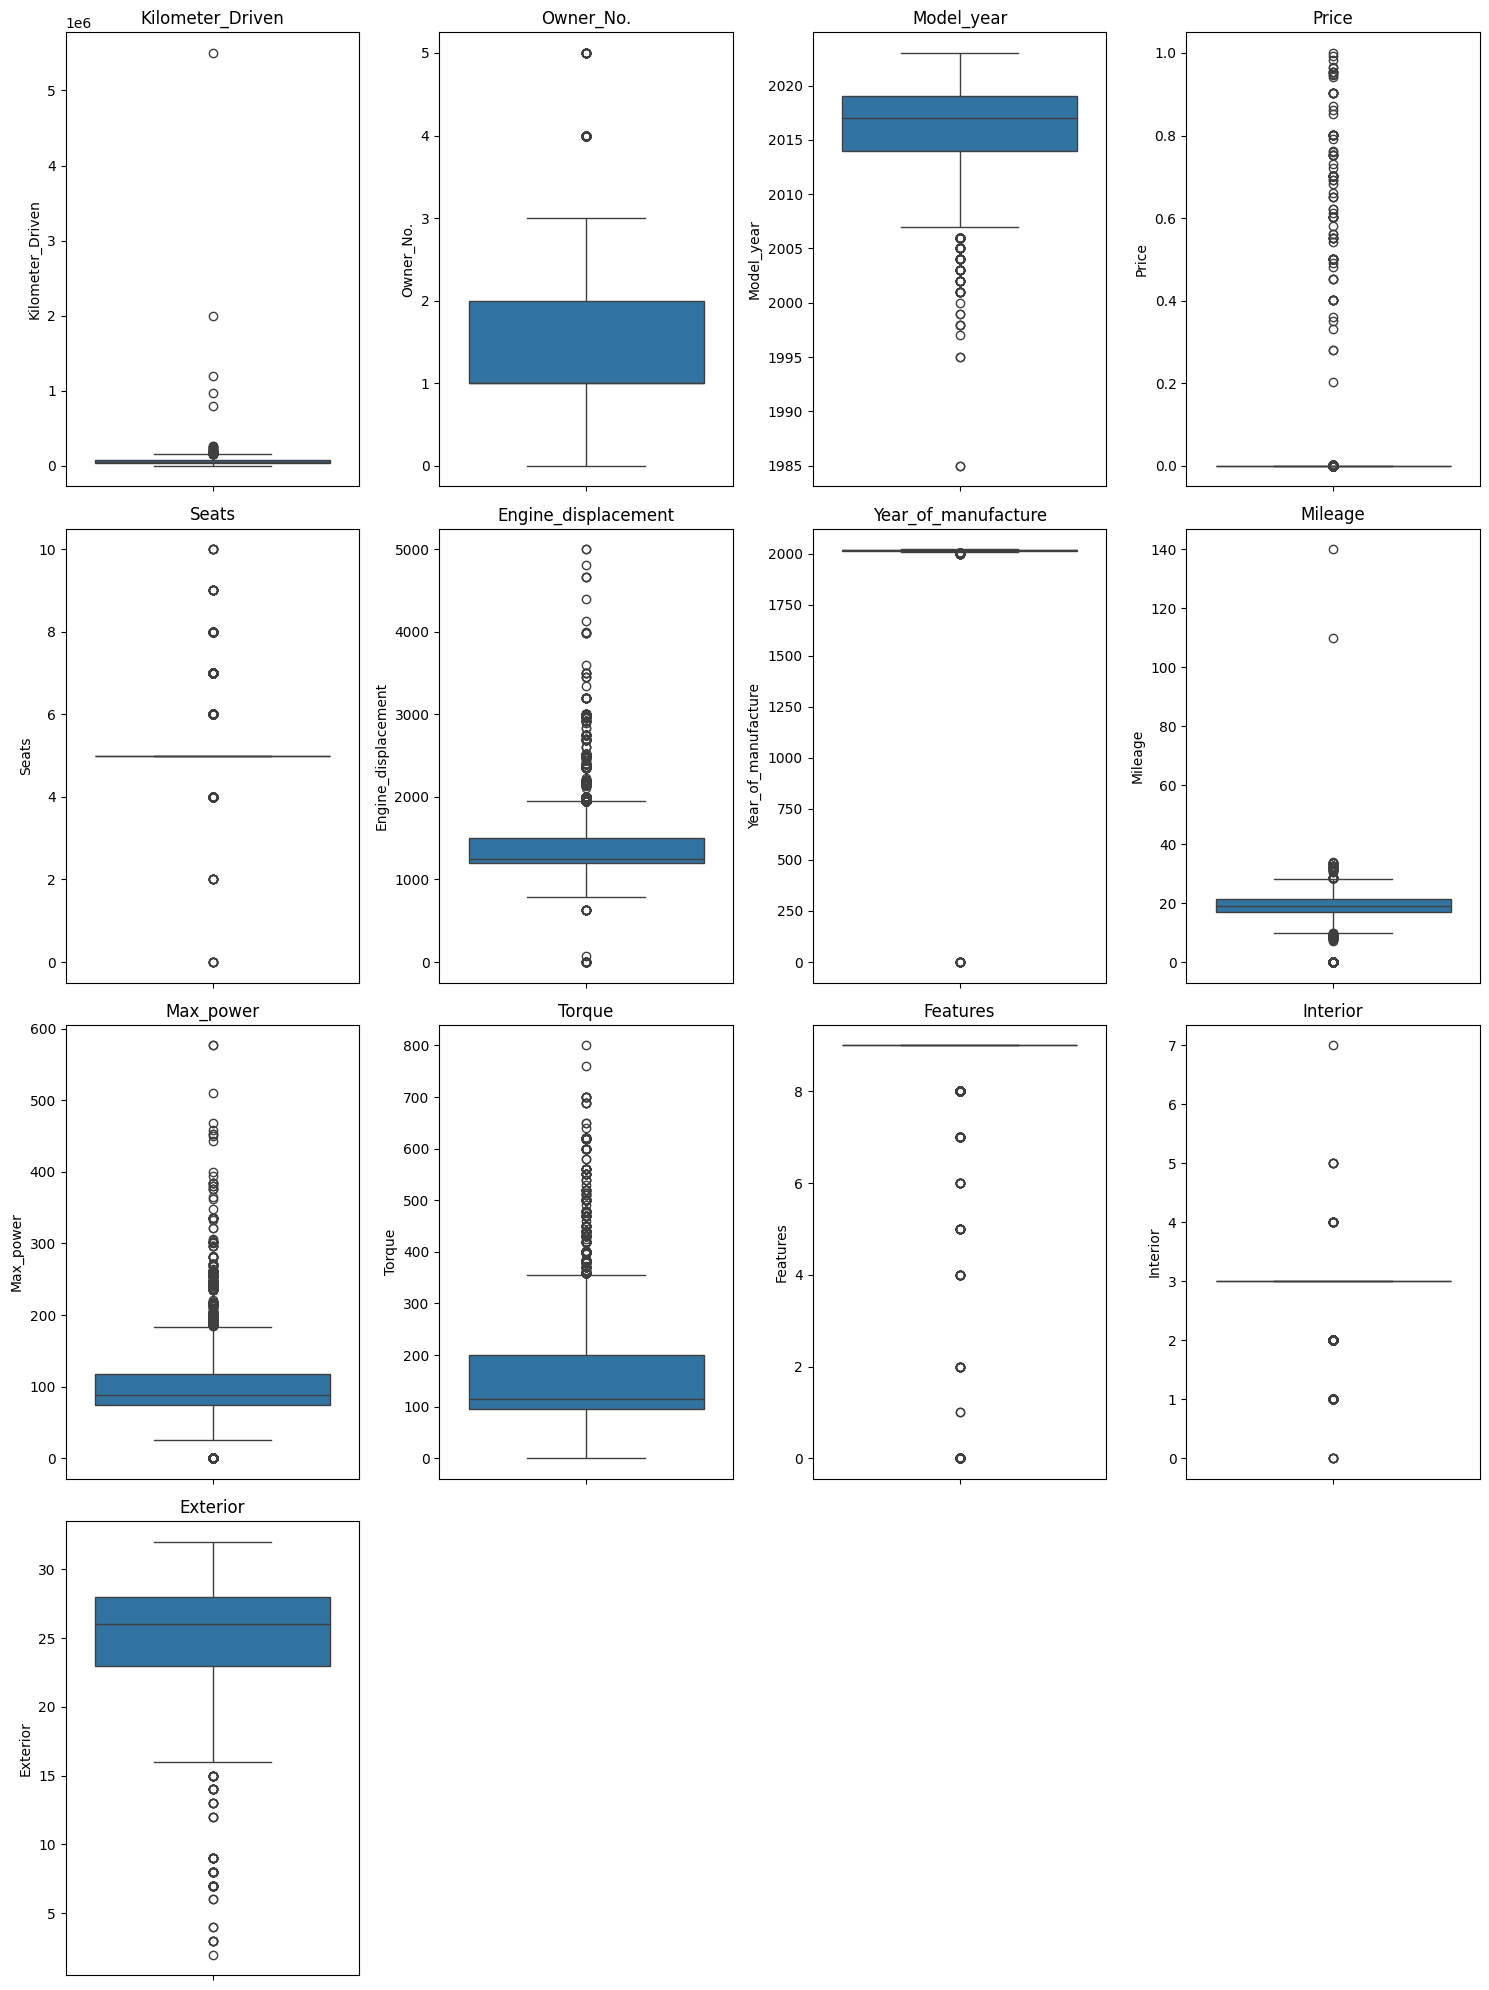

In [86]:
def plot_boxplots(combined_df, columns):
    num_cols = len(columns)
    num_rows = int(np.ceil(num_cols / 4))  
    num_cols_subplot = min(num_cols, 4)  
    plt.figure(figsize=(15, 5 * num_rows))  
    
    for i, column in enumerate(columns):
        plt.subplot(num_rows, num_cols_subplot, i + 1)  
        sns.boxplot(combined_df[column])
        plt.title(column)
    
    plt.tight_layout()
    plt.show()

numerical_cols = combined_df.select_dtypes(include=['float', 'int']).columns
plot_boxplots(combined_df, numerical_cols)

In [87]:
def descriptive_statistics(df):
    stats = pd.DataFrame({
        'Mean': df.mean(),
        'Median': df.median(),
        'Mode': df.mode().iloc[0],
        'Std Dev': df.std(),
        'Min': df.min(),
        'Max': df.max()
    })
    return stats

numerical_cols = combined_df.select_dtypes(include=['float', 'int']).columns
stats_df = descriptive_statistics(combined_df[numerical_cols])

print("Descriptive Statistics:\n")
print(stats_df)

Descriptive Statistics:

                             Mean        Median           Mode       Std Dev  \
Kilometer_Driven     58974.302426  53692.000000  120000.000000  74060.999945   
Owner_No.                1.360139      1.000000       1.000000      0.641958   
Model_year            2016.503286   2017.000000    2018.000000      3.921465   
Price                    0.008917      0.000062       0.000065      0.079386   
Seats                    5.199546      5.000000       5.000000      0.678011   
Engine_displacement   1424.054965   1248.000000    1197.000000    478.529403   
Year_of_manufacture   2011.728761   2017.000000    2018.000000     98.541131   
Mileage                 18.473264     18.900000       0.000000      5.379348   
Max_power              102.170531     88.500000      88.500000     49.005189   
Torque                 161.066794    115.000000       0.000000    118.179108   
Features                 8.778229      9.000000       9.000000      0.927743   
Interior       

In [88]:
def cap_outliers_iqr(combined_df, columns):
    for col in columns:
        Q1 = combined_df[col].quantile(0.25)
        Q3 = combined_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        combined_df[col] = np.clip(combined_df[col], lower_bound, upper_bound)
    return combined_df

In [89]:
def plot_histograms(combined_df, columns):
    combined_df[columns].hist(figsize=(15, 10), bins=30, edgecolor='black')
    plt.tight_layout()
    plt.show()


In [90]:
def plot_boxplots(combined_df, columns):
    num_cols = len(columns)
    num_rows = int(np.ceil(num_cols / 4))  
    num_cols_subplot = min(num_cols, 4)  
    plt.figure(figsize=(15, 5 * num_rows)) 
   
    for i, column in enumerate(columns):
        if combined_df[column].nunique() > 1:  
            plt.subplot(num_rows, num_cols_subplot, i + 1)  
            sns.boxplot(data=combined_df[column])
            plt.title(column)
        else:
            print(f"Skipping box plot for {column} due to limited variance.")
   
    plt.tight_layout()
    plt.show()

In [91]:
def plot_scatter_plots(combined_df, x_cols, y_cols):
    plt.figure(figsize=(15, 10))
    for i, x in enumerate(x_cols):
        for j, y in enumerate(y_cols):
            plt.subplot(len(x_cols), len(y_cols), i*len(y_cols) + j + 1)
            sns.scatterplot(data=combined_df, x=x, y=y)
            plt.title(f'{x} vs {y}')
    plt.tight_layout()
    plt.show()

In [92]:
def plot_correlation_heatmap_fix(combined_df):
    numeric_df = combined_df.select_dtypes(include=['float64', 'int64'])
   
    numeric_df = numeric_df.dropna(axis=1, how='all')
   
    plt.figure(figsize=(12, 8))
    correlation_matrix = numeric_df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap')
    plt.show()


In [93]:
numeric_cols = combined_df.select_dtypes(include=['float64', 'int64']).columns
cols_to_plot = [col for col in numeric_cols if combined_df[col].nunique() > 1 and combined_df[col].std() > 0]
combined_df = cap_outliers_iqr(combined_df, cols_to_plot)

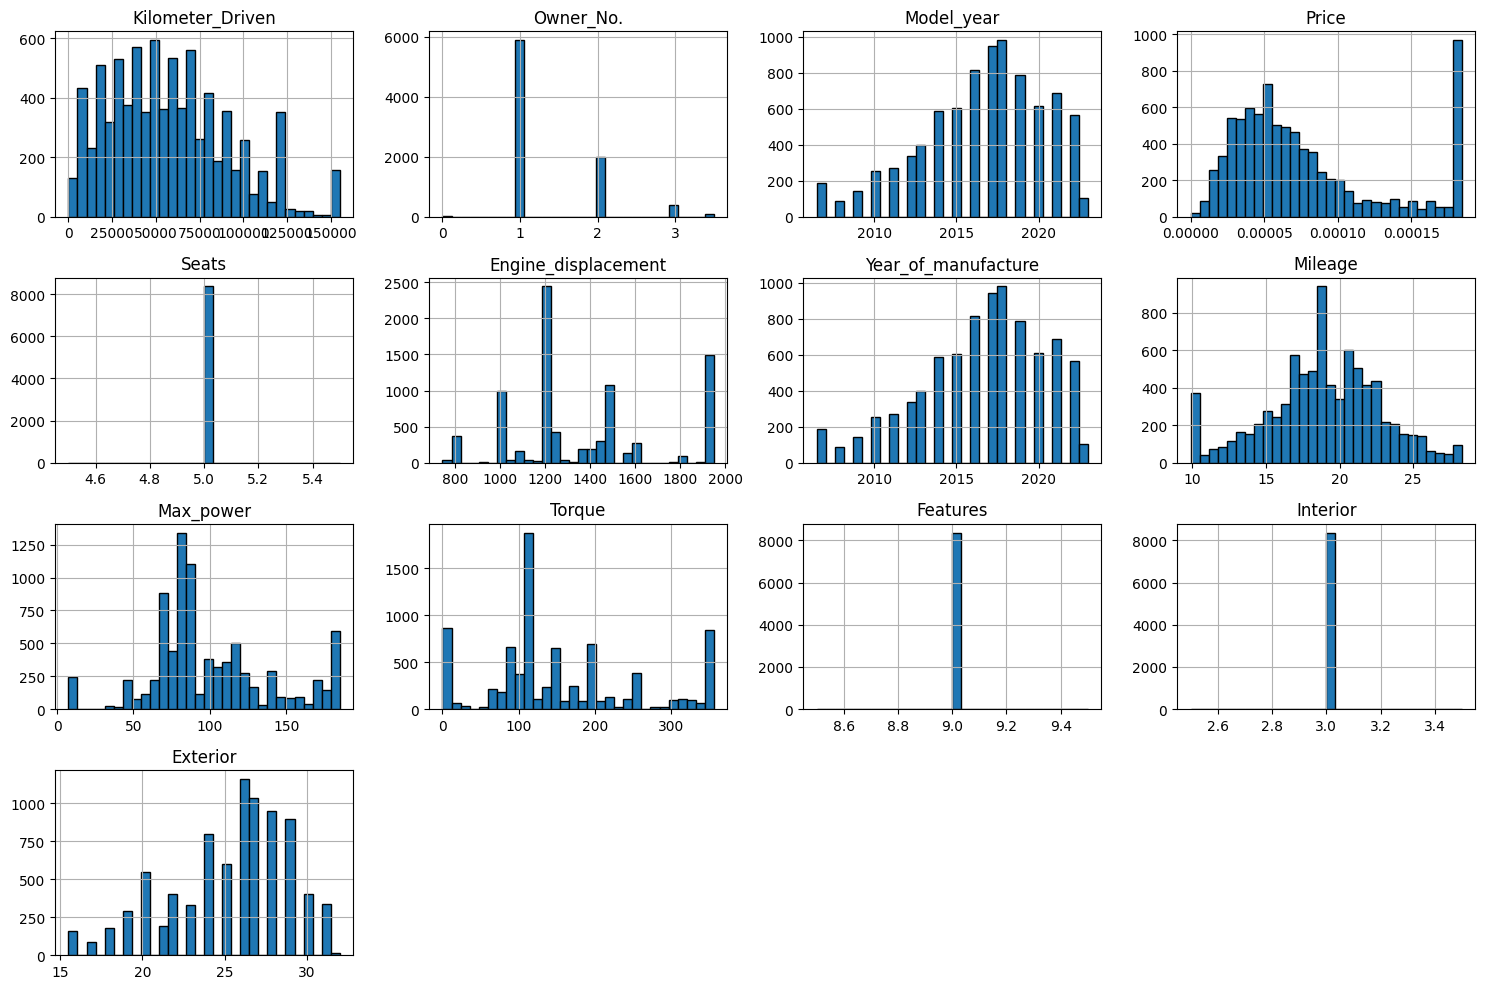

Skipping box plot for Seats due to limited variance.
Skipping box plot for Features due to limited variance.
Skipping box plot for Interior due to limited variance.


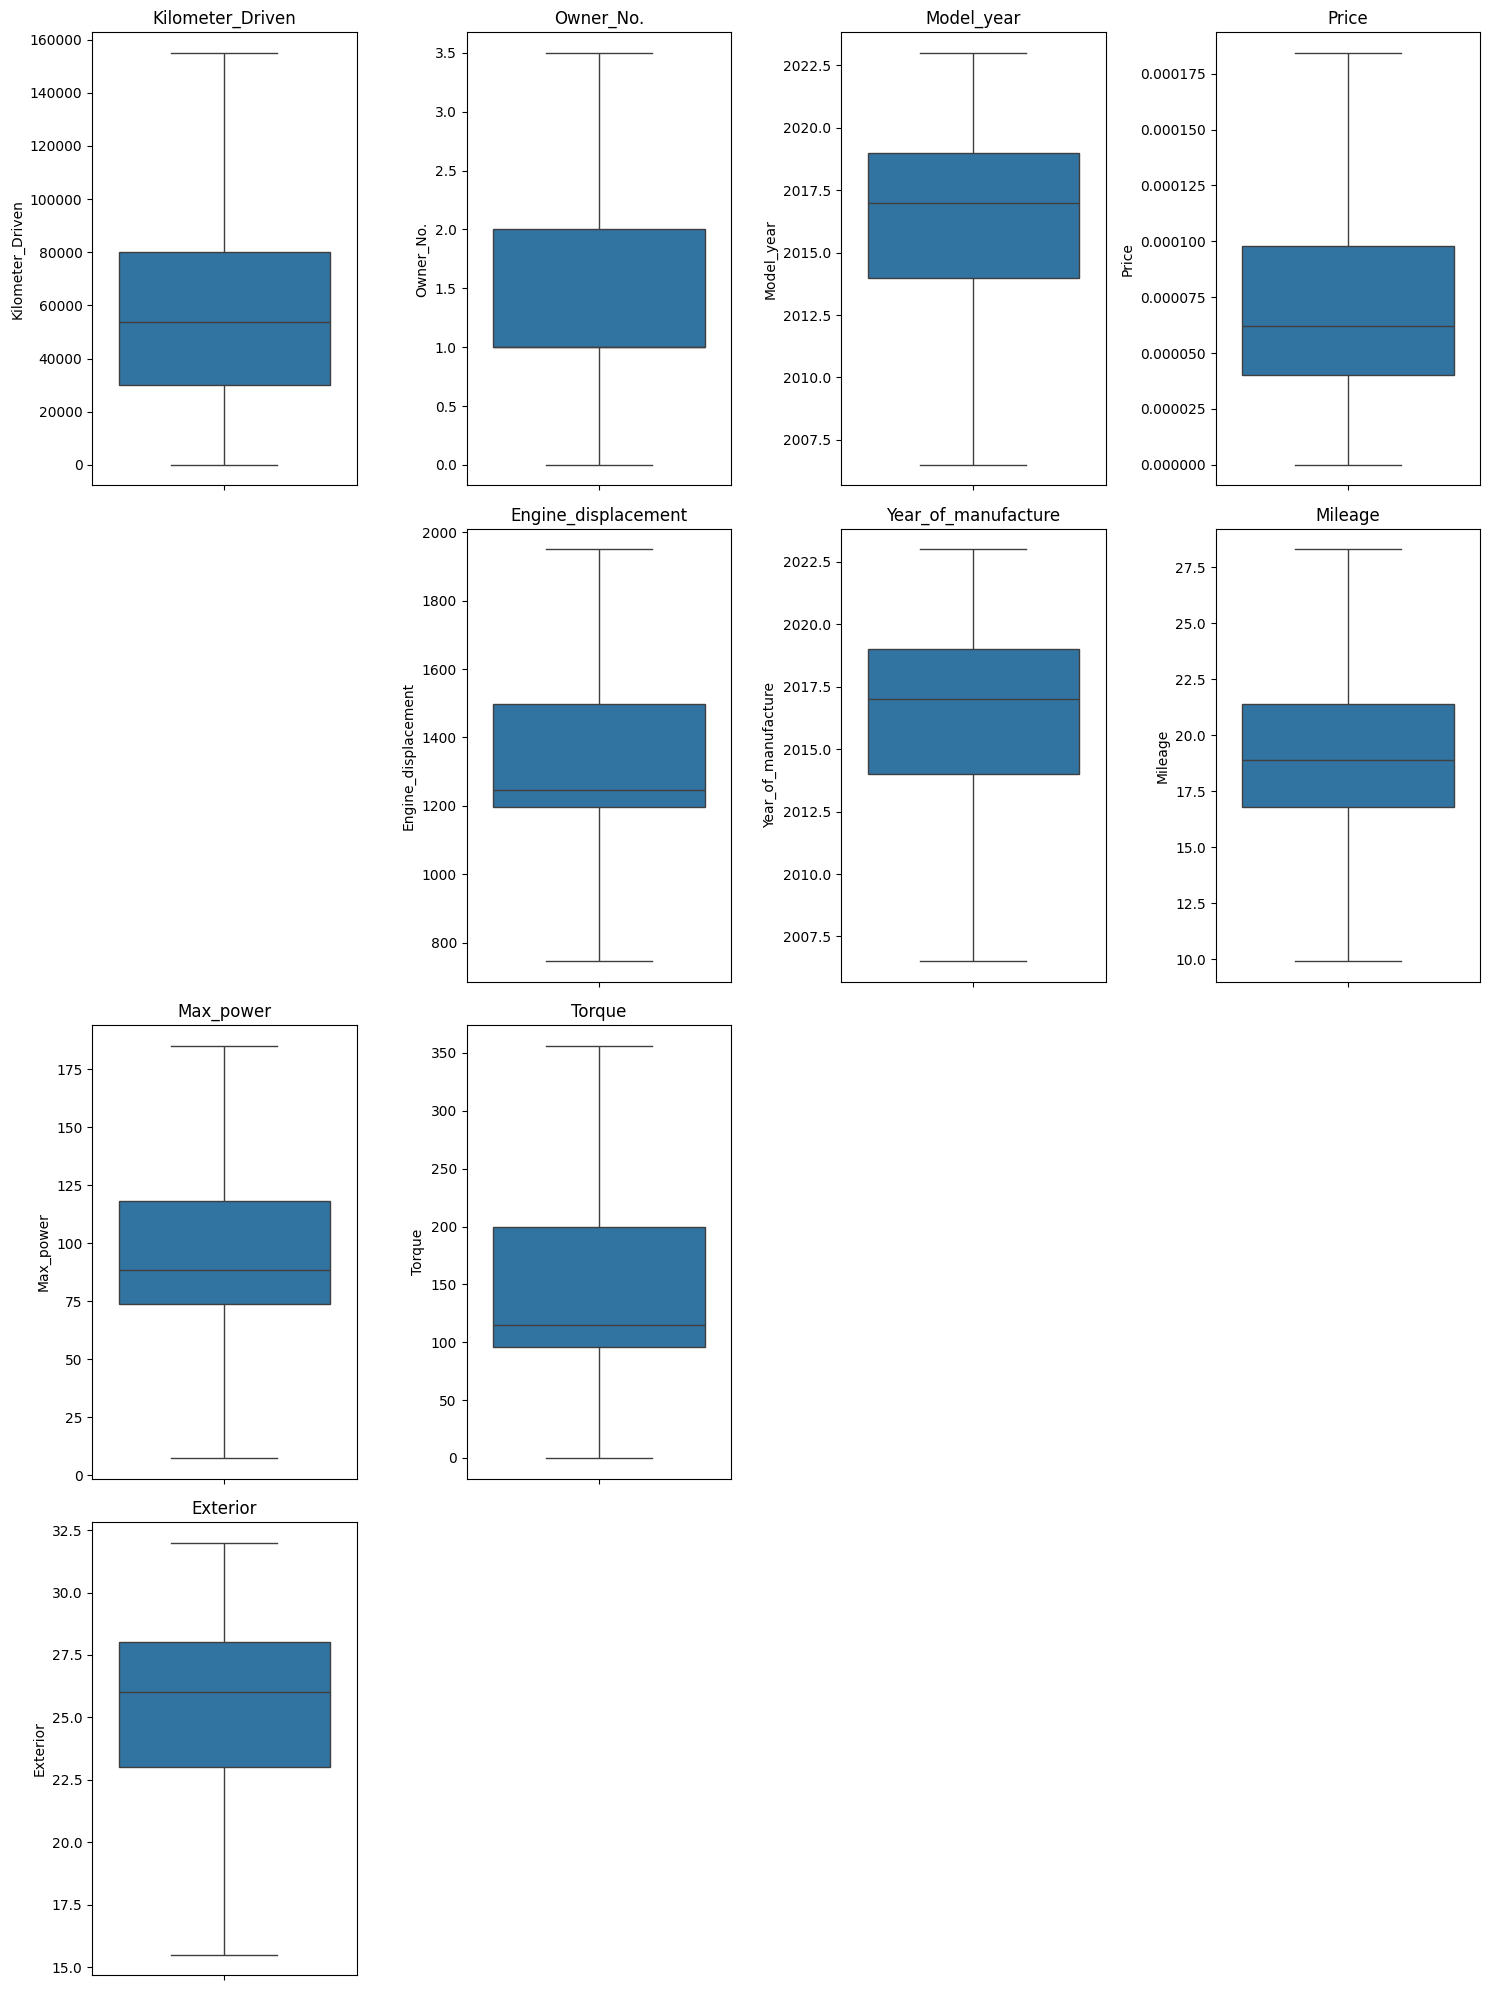

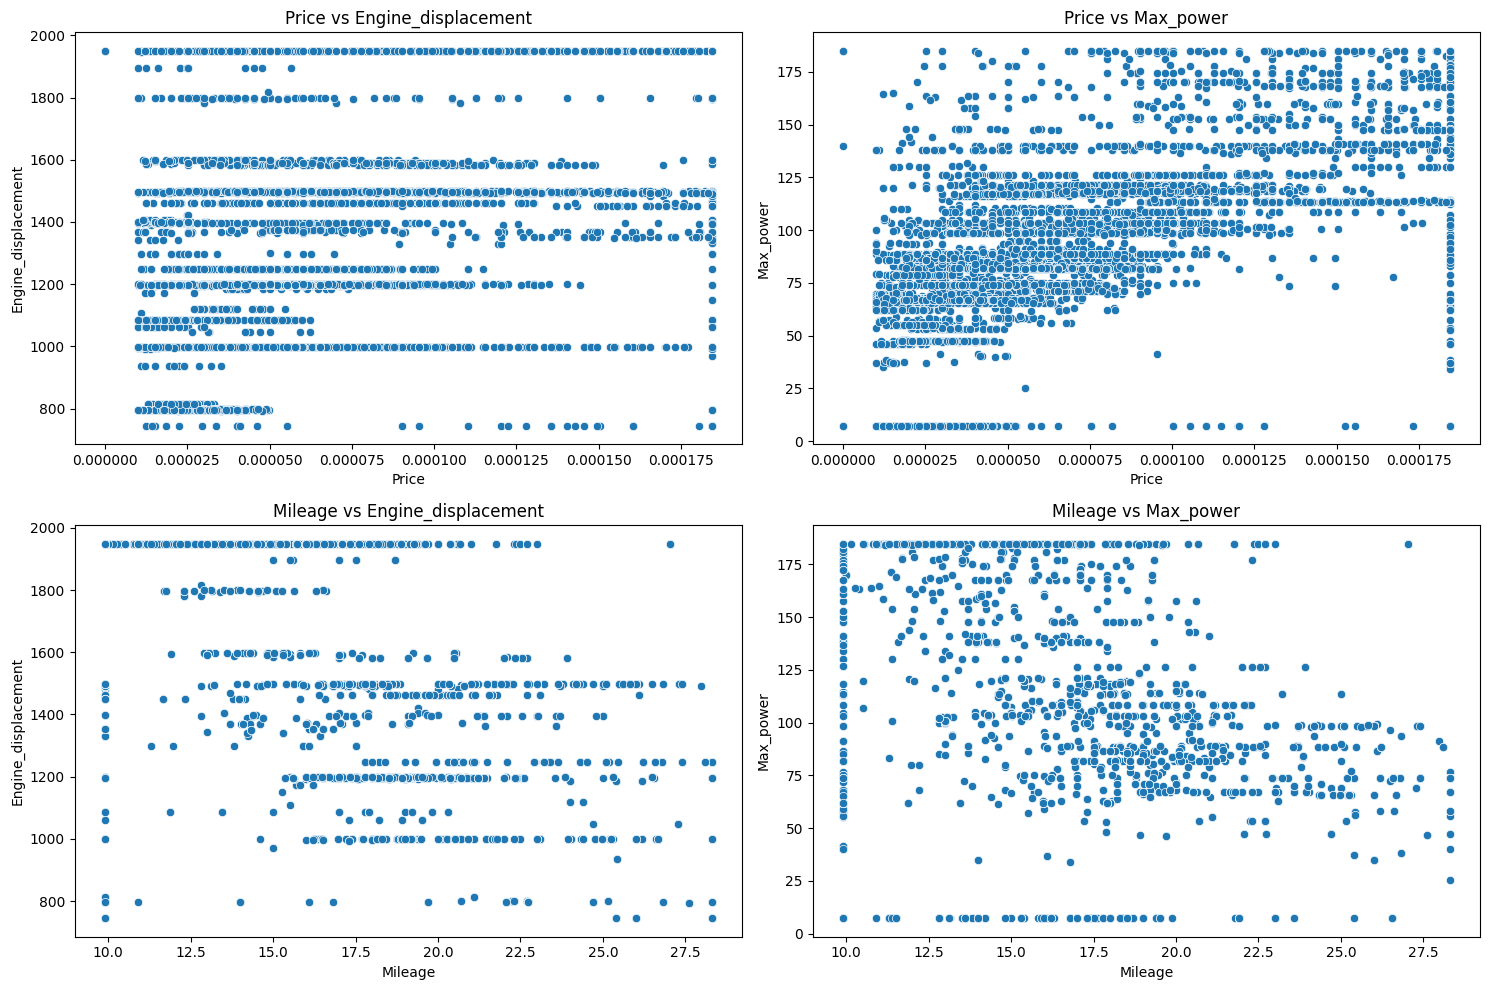

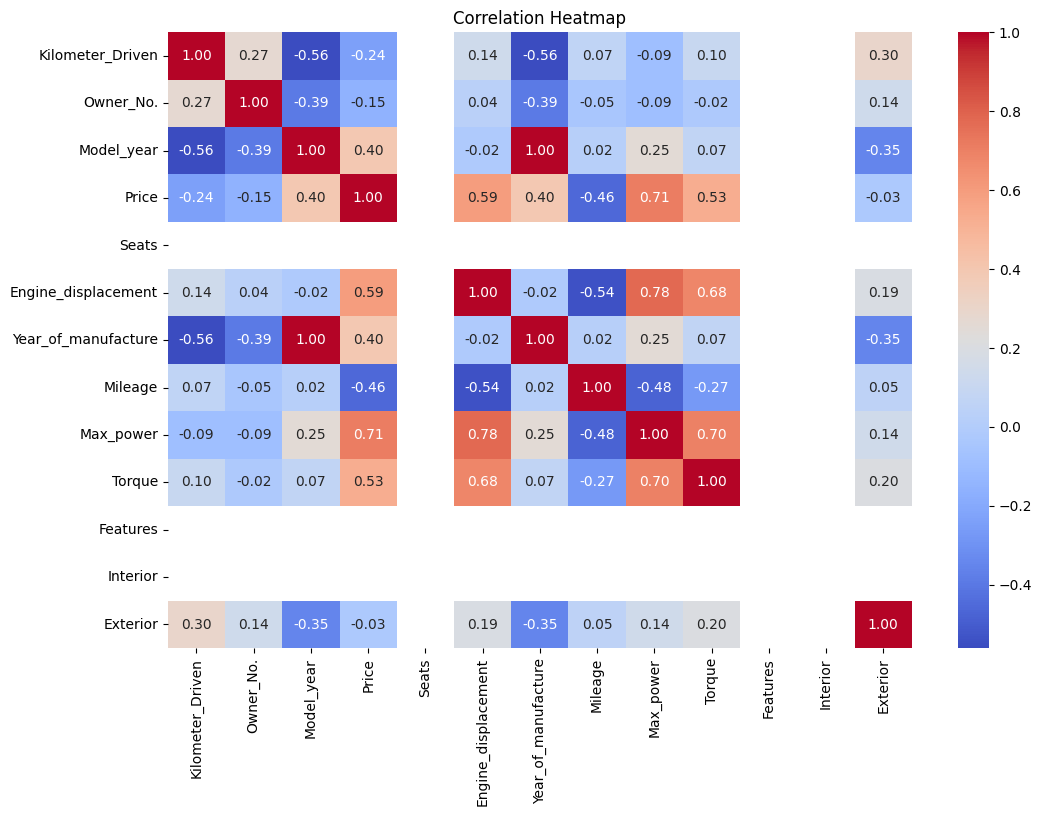

In [94]:
plot_histograms(combined_df, cols_to_plot)
plot_boxplots(combined_df, cols_to_plot)
plot_scatter_plots(combined_df, ['Price', 'Mileage'], ['Engine_displacement', 'Max_power'])
plot_correlation_heatmap_fix(combined_df[cols_to_plot])

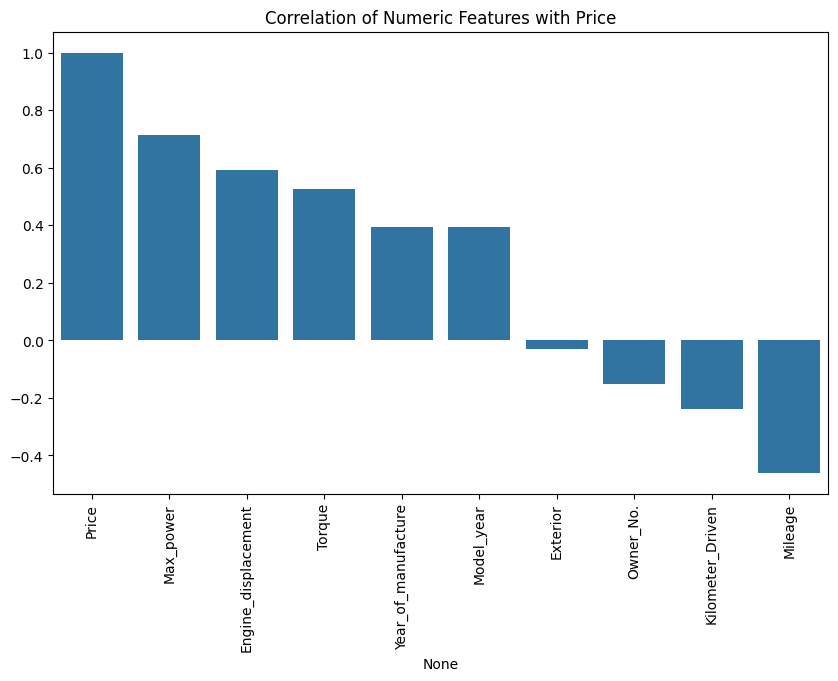

Features with high correlation with Price:
 Price                  1.000000
Max_power              0.711973
Engine_displacement    0.591723
Torque                 0.527243
Year_of_manufacture    0.395368
Model_year             0.395368
Exterior              -0.030039
Owner_No.             -0.152927
Kilometer_Driven      -0.238395
Mileage               -0.459865
Name: Price, dtype: float64


In [95]:
numeric_cols = combined_df.select_dtypes(include=['float64', 'int64']).columns

numeric_cols = [col for col in numeric_cols if col not in ['Seats', 'Interior', 'Features']]

correlation_matrix = combined_df[numeric_cols].corr()

correlation_with_price = correlation_matrix['Price'].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_price.index, y=correlation_with_price.values)
plt.xticks(rotation=90)
plt.title('Correlation of Numeric Features with Price')
plt.show()

print("Features with high correlation with Price:\n", correlation_with_price)

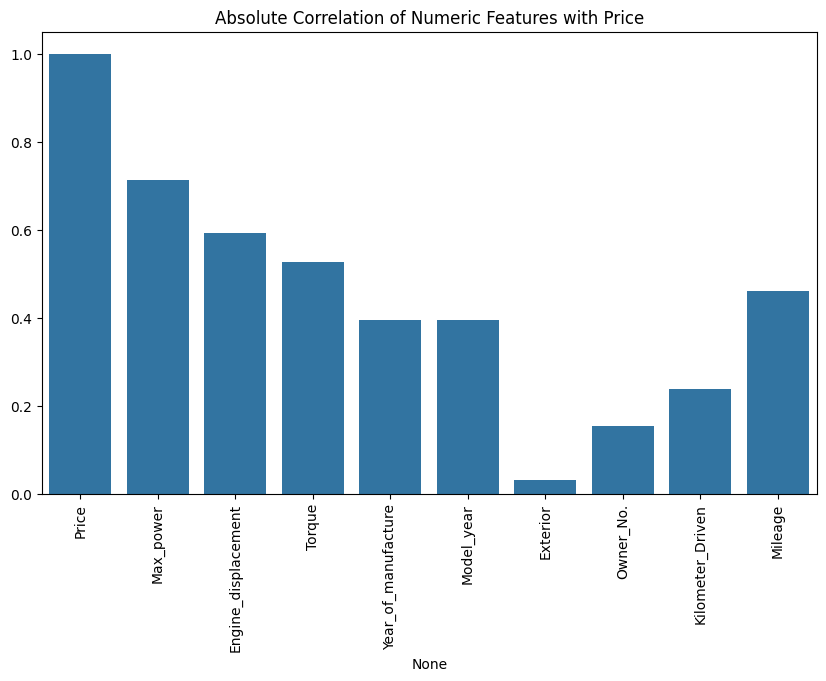

Features with high absolute correlation with Price:
 Price                  1.000000
Max_power              0.711973
Engine_displacement    0.591723
Torque                 0.527243
Year_of_manufacture    0.395368
Model_year             0.395368
Exterior               0.030039
Owner_No.              0.152927
Kilometer_Driven       0.238395
Mileage                0.459865
Name: Price, dtype: float64


In [96]:
correlation_with_price_abs = np.abs(correlation_with_price)

plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_price_abs.index, y=correlation_with_price_abs.values)
plt.xticks(rotation=90)
plt.title('Absolute Correlation of Numeric Features with Price')
plt.show()

print("Features with high absolute correlation with Price:\n", correlation_with_price_abs)

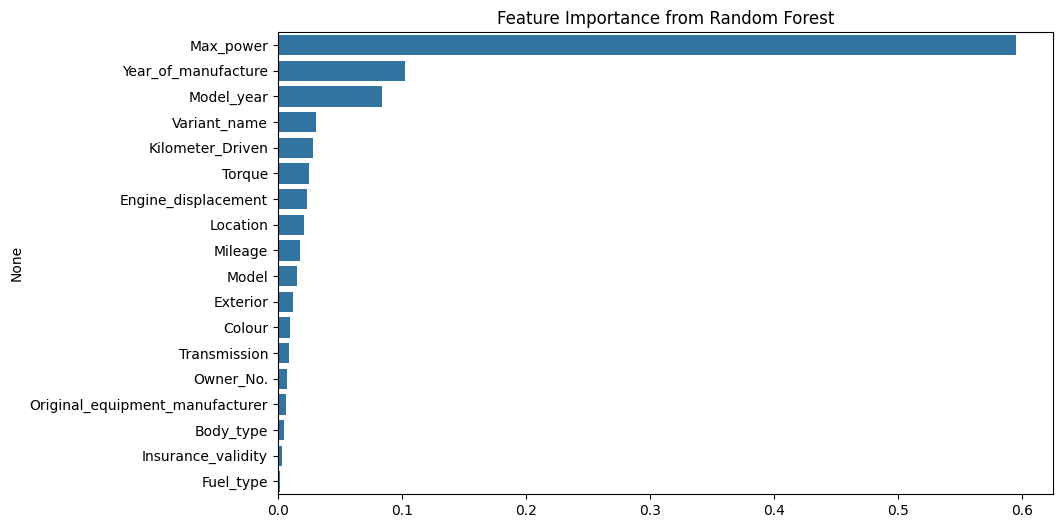

Top features based on importance:
 Max_power                          0.595121
Year_of_manufacture                0.102681
Model_year                         0.084296
Variant_name                       0.030794
Kilometer_Driven                   0.028381
Torque                             0.024849
Engine_displacement                0.023254
Location                           0.021471
Mileage                            0.018066
Model                              0.015276
Exterior                           0.012334
Colour                             0.009609
Transmission                       0.008913
Owner_No.                          0.007510
Original_equipment_manufacturer    0.006628
Body_type                          0.005416
Insurance_validity                 0.003372
Fuel_type                          0.002028
dtype: float64


In [97]:
categorical_columns = combined_df.select_dtypes(include=['object']).columns
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    combined_df[col] = le.fit_transform(combined_df[col].astype(str))
    label_encoders[col] = le

X = combined_df.drop(['Price', 'Seats', 'Interior', 'Features'], axis=1)  
y = combined_df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title('Feature Importance from Random Forest')
plt.show()

print("Top features based on importance:\n", feature_importance)

In [98]:
selected_features = [
    'Mileage', 'Engine_displacement', 'Year_of_manufacture',
    'Transmission', 'Fuel_type', 'Owner_No.', 
    'Model_year', 'Location', 'Kilometer_Driven', 'Body_type'
]

final_df = combined_df[selected_features + ['Price']]

final_df.head()

,Mileage,Engine_displacement,Year_of_manufacture,Transmission,Fuel_type,Owner_No.,Model_year,Location,Kilometer_Driven,Body_type,Price
0,23.10,998.0,2015.0,1,4,3.0,2015.0,0,120000,3,0.000040
1,17.00,1497.0,2018.0,1,4,2.0,2018.0,0,32706,8,0.000081
2,23.84,1199.0,2018.0,1,4,1.0,2018.0,0,11949,3,0.000059
3,19.10,1197.0,2014.0,1,4,1.0,2014.0,0,17794,9,0.000046
4,23.65,1248.0,2015.0,1,1,1.0,2015.0,0,60000,8,0.000079


In [100]:
final_df

,Mileage,Engine_displacement,Year_of_manufacture,Transmission,Fuel_type,Owner_No.,Model_year,Location,Kilometer_Driven,Body_type,Price
0,23.10,998.0,2015.0,1,4,3.0,2015.0,0,120000,3,0.000040
1,17.00,1497.0,2018.0,1,4,2.0,2018.0,0,32706,8,0.000081
2,23.84,1199.0,2018.0,1,4,1.0,2018.0,0,11949,3,0.000059
3,19.10,1197.0,2014.0,1,4,1.0,2014.0,0,17794,9,0.000046
4,23.65,1248.0,2015.0,1,1,1.0,2015.0,0,60000,8,0.000079
...,...,...,...,...,...,...,...,...,...,...,...
8364,25.24,998.0,2022.0,1,4,1.0,2022.0,5,10000,3,0.000051
8365,22.74,796.0,2014.0,1,4,1.0,2014.0,5,120000,3,0.000018
8366,11.74,1796.0,2011.0,0,4,3.0,2011.0,5,50000,9,0.000055
8367,18.50,1197.0,2012.0,1,4,1.0,2012.0,5,40000,3,0.000014


In [101]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8369 entries, 0 to 8368
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Mileage              8369 non-null   float64
 1   Engine_displacement  8369 non-null   float64
 2   Year_of_manufacture  8369 non-null   float64
 3   Transmission         8369 non-null   int64  
 4   Fuel_type            8369 non-null   int64  
 5   Owner_No.            8369 non-null   float64
 6   Model_year           8369 non-null   float64
 7   Location             8369 non-null   int64  
 8   Kilometer_Driven     8369 non-null   int64  
 9   Body_type            8369 non-null   int64  
 10  Price                8369 non-null   float64
dtypes: float64(6), int64(5)
memory usage: 719.3 KB


In [102]:
X = final_df.drop('Price', axis=1)
y = final_df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [103]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6695, 10), (1674, 10), (6695,), (1674,))

In [104]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor()
}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)  
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"--- {name} Results ---")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R-squared (R2): {r2}")
    print("-" * 30)

Training Linear Regression...
--- Linear Regression Results ---
Mean Squared Error (MSE): 1.0736647126470963e-09
Root Mean Squared Error (RMSE): 3.276682335300596e-05
Mean Absolute Error (MAE): 2.074005411272945e-05
R-squared (R2): 0.5954223856802167
------------------------------
Training Decision Tree...
--- Decision Tree Results ---
Mean Squared Error (MSE): 8.580955633196486e-10
Root Mean Squared Error (RMSE): 2.9293268225304745e-05
Mean Absolute Error (MAE): 1.3396776748328443e-05
R-squared (R2): 0.676653007426943
------------------------------
Training Random Forest...


c:\Users\navee\OneDrive\Desktop\Car Dheko_Used Car Price Prediction\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\navee\OneDrive\Desktop\Car Dheko_Used Car Price Prediction\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\navee\OneDrive\Desktop\Car Dheko_Used Car Price Prediction\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


--- Random Forest Results ---
Mean Squared Error (MSE): 5.382651568331451e-10
Root Mean Squared Error (RMSE): 2.320054216679311e-05
Mean Absolute Error (MAE): 1.1258825164018884e-05
R-squared (R2): 0.7971712859165216
------------------------------
Training Gradient Boosting...
--- Gradient Boosting Results ---
Mean Squared Error (MSE): 6.443297981750884e-10
Root Mean Squared Error (RMSE): 2.538365218354302e-05
Mean Absolute Error (MAE): 1.4321312480262147e-05
R-squared (R2): 0.7572040791597587
------------------------------


c:\Users\navee\OneDrive\Desktop\Car Dheko_Used Car Price Prediction\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [105]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")

y_pred = best_rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Best Parameters:", best_params)
print("\n--- Random Forest Model Results ---")
print(f"Mean Squared Error (MSE): {mse:.5f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.5f}")
print(f"R-squared (R2): {r2:.5f}")
print("-" * 30)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}

--- Random Forest Model Results ---
Mean Squared Error (MSE): 0.00000
Root Mean Squared Error (RMSE): 0.00002
R-squared (R2): 0.80011
------------------------------


c:\Users\navee\OneDrive\Desktop\Car Dheko_Used Car Price Prediction\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [106]:
import joblib
joblib.dump(best_rf_model, 'rf_trainedmodel.pkl')
print("Model saved as rf_trainedmodel.pkl")
joblib.dump(label_encoders, 'label_encoders.pkl')
print("Label encoders saved as label_encoders.pkl")
joblib.dump(scaler_2, 'min.pkl')
print("Scaler saved as min.pkl")

Model saved as rf_trainedmodel.pkl
Label encoders saved as label_encoders.pkl
Scaler saved as min.pkl


In [107]:
import pandas as pd
import joblib

loaded_model = joblib.load('rf_trainedmodel.pkl')
loaded_encoders = joblib.load('label_encoders.pkl')
loaded_scaler = joblib.load('min.pkl')

categorical_columns = [
    "Body_type",
    "Transmission",
    "Original_equipment_manufacturer",
    "Model",
    "Variant_name",
    "Insurance_validity",
    "Fuel_type",
    "Colour",
    "Location",
]

def predict_price(
    mileage,
    engine_displacement,
    year_of_manufacture,
    transmission,
    fuel_type,
    owner_no,
    model_year,
    location,
    kilometer_driven,
    body_type,
):
    input_data = pd.DataFrame(
        {
            "Mileage": [mileage],
            "Engine_displacement": [engine_displacement],
            "Year_of_manufacture": [year_of_manufacture],
            "Transmission": [transmission],
            "Fuel_type": [fuel_type],
            "Owner_No.": [owner_no],
            "Model_year": [model_year],
            "Location": [location],
            "Kilometer_Driven": [kilometer_driven],
            "Body_type": [body_type],
        }
    )

    for col in categorical_columns:
        if col in input_data.columns:
            le = loaded_encoders[col]
            input_data[col] = le.transform(input_data[col].astype(str))

    predicted_price = loaded_model.predict(input_data)
    predicted_price_norm = loaded_scaler.inverse_transform([[predicted_price[0]]])[0][0]
    return predicted_price_norm

mileage = float(input("Enter MILEAGE: "))
engine_displacement = float(input("Enter ENGINE DISPLACEMENT: "))
year_of_manufacture = int(input("Enter YEAR OF MANUFACTURE: "))
transmission = input("Enter TRANSMISSION (e.g., Manual, Automatic): ")
fuel_type = input("Enter FUEL TYPE (e.g., Petrol, Diesel): ")
owner_no = int(input("Enter OWNER NO.: "))
model_year = int(input("Enter MODEL YEAR: "))
location = input("Enter LOCATION: ")
kilometer_driven = float(input("Enter KILOMETER DRIVEN: "))
body_type = input("Enter BODY TYPE: ")

predicted_price = predict_price(
    mileage,
    engine_displacement,
    year_of_manufacture,
    transmission,
    fuel_type,
    owner_no,
    model_year,
    location,
    kilometer_driven,
    body_type,
)

print(f"Predicted Price: {predicted_price}")


Predicted Price: 814708.7616723181


In [109]:
final_df.loc[:, 'Car_Age'] = 2024 - final_df['Year_of_manufacture']

final_df.loc[:, 'Mileage_Displacement'] = final_df['Mileage'] * final_df['Engine_displacement']

columns_to_drop = ['Price', 'Seats', 'Interior', 'Features']
existing_columns_to_drop = [col for col in columns_to_drop if col in final_df.columns]

X = final_df.drop(existing_columns_to_drop, axis=1)
y = final_df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [110]:
from sklearn.linear_model import Ridge, Lasso

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)
print(f"Ridge Regression MSE: {mean_squared_error(y_test, ridge_pred)}")

lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)
print(f"Lasso Regression MSE: {mean_squared_error(y_test, lasso_pred)}")

Ridge Regression MSE: 9.896261898262245e-10
Lasso Regression MSE: 2.5205491315295914e-09


In [111]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X = final_df.drop(['Price', 'Seats', 'Interior', 'Features'], axis=1, errors='ignore')
y = final_df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    print(f"{name} MSE: {mse}")

Random Forest MSE: 5.319040878402069e-10
Ridge Regression MSE: 9.896261898262245e-10
Lasso Regression MSE: 2.5205491315295914e-09


In [112]:
import joblib
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
joblib.dump(ridge_model, 'ridge_model.pkl')

['ridge_model.pkl']